In [1]:
import os
import sys
import time
import yaml
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.constants import c
from lib.formulary import BunchLength
from lib.loadlattice import prepareTwiss
from lib.IBSfunctions import NagaitsevIBS
from lib.separatrix import def_separatrix, is_in_separtrx

from blond.beam.beam import Beam, Proton
from blond.input_parameters.ring import Ring
from blond.monitors.monitors import BunchMonitor
from blond.input_parameters.rf_parameters import RFStation
from blond.beam.profile import CutOptions, FitOptions, Profile
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import bigaussian, matched_from_distribution_function

### LHC Parameters

In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# !~~~~~~~~~~~~ Bunch parameters ~~~~~~~~~~~! #
N_b = config['bunch_intensity'] # Number of particles; [1]
N_p = int(config['n_mparts'])   # Number of macro-particles; [1]
tau_0 = config['tau']           # 4 sigma bunch length, 4 sigma [s]

# !~~~~~~~ Machine and RF parameters ~~~~~~~! #
C = 26658.883                       # Machine circumference [m]
p = config['energy'] * 1e9      # Synchronous momentum [eV/c]
h = config['h']                 # Harmonic number
phi = 0.                        # RF synchronous phase
Vrf = config['V0max'] * 1e9     # RF voltage [V]

gamma_t = 53.8                  # Transition gamma
alpha   = 1 / gamma_t**2        # First order mom. comp. factor

# !~~~~~~~~~~~~ Tracking details ~~~~~~~~~~~! #
N_t    = int(config['N_turns']) # Number of turns to track
N_ibs  = int(config['IBS_stp']) # Number of turns to update IBS
N_mtch = 10000                  # Number of turns for matching
dt_plt = 50

print(f'Circumference: {C} [m],\nHarmonic number: {h}, \nVrf: {Vrf} [V], \ngamma transition: {gamma_t}, \nmomentum compaction factor: {alpha}\n')
print(f'Bunch intensity: {N_b} electrons,\nNumber of macroparticles: {N_p}, \nBunch length: {tau_0} ns, \nEnergy: {p * 1e-9} [GeV]')

Circumference: 26658.883 [m],
Harmonic number: 35640.0, 
Vrf: 5000000.0 [V], 
gamma transition: 53.8, 
momentum compaction factor: 0.000345489973880958

Bunch intensity: 1.6e11 electrons,
Number of macroparticles: 100000, 
Bunch length: 1.2e-09 ns, 
Energy: 450.0 [GeV]


### Simulation Setup

Working directory is /Users/michalis/Work/Fellow/IBS_BLonD/LHC
Ring initialized...
RF station initialized...
Matching the bunch... (iteration: 0 and sse: 0.0)
Intensity = 1.60e+11 ppb
4sigma bunch length requested = 1.2e-09 [s]
4sigma bunch length from profile = 1.1999322016322165e-09 [s]
4sigma bunch length from np.std = 1.198849798711171e-09 s
Energy spread = 0.0002540501883694722
Turn = 1000
Turn = 2000
Turn = 3000
Turn = 4000
Turn = 5000
Turn = 6000
Turn = 7000
Turn = 8000
Turn = 9000
Turn = 10000
Intensity = 1.60e+11 ppb
4sigma bunch length requested = 1.2e-09 [s]
4sigma bunch length from profile = 1.2009214946624594e-09 [s]
4sigma bunch length from np.std = 1.2000530045267074e-09 s
Energy spread = 0.0002538983984041391


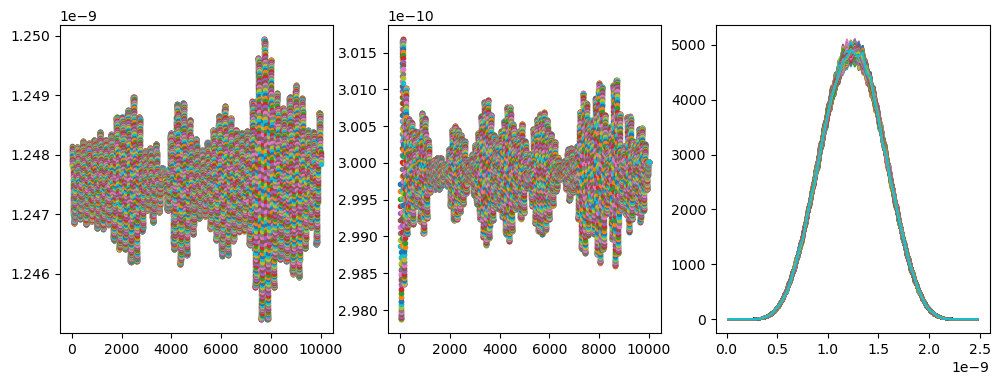

In [3]:
wrkDir = os.getcwd()
print(f"Working directory is {wrkDir}")
if not os.path.isdir(os.path.join(wrkDir,'output')):
    os.mkdir("output")
    print(f"Created output folder {os.path.join(wrkDir,'output')}")

# !~~~~~~~ Define General Parameters ~~~~~~~! #
ring = Ring(C, alpha, p, Proton(), N_t + N_mtch)
print("Ring initialized...")

# !~~~~~~ Define RF Station Parameters ~~~~~! #
rf = RFStation(ring, [h], [Vrf], [phi])
print("RF station initialized...")


# !~~~~~~ Define beam and distribution ~~~~~! #
beam = Beam(ring, N_p, N_b)

n_slices = 64
profile = Profile(beam, CutOptions(n_slices = n_slices, cut_left=0, 
                    cut_right=rf.t_rf[0, 0]), 
                    FitOptions=FitOptions(fit_option='rms'))

# !~~~~~~~~~~~~ Define Separatrix ~~~~~~~~~~! #
Hsep = def_separatrix(ring, rf, beam)

# !~~~~~~~~~~~~~~~~ Trackers ~~~~~~~~~~~~~~~! #
rf_station_tracker = RingAndRFTracker(rf, beam, Profile=profile)
tracker = FullRingAndRF([rf_station_tracker])


# !~~~~~~~~~~~~~~~~ Matching ~~~~~~~~~~~~~~! #
# matched_from_distribution_function(beam, tracker,
#     distribution_type = 'gaussian', bunch_length = tau_0,
#     distribution_variable = 'Hamiltonian', bunch_length_fit = 'gaussian', 
#     n_iterations= 10)

matched_from_distribution_function(beam, tracker,
    distribution_type = 'binomial', bunch_length = tau_0, distribution_exponent = 2,
    distribution_variable = 'Hamiltonian', bunch_length_fit = 'gaussian', 
    n_iterations= 10)

# bigaussian(ring, rf, beam, tau_0 /4., seed = 431424123)

profile.track()

print(f'Intensity = {beam.ratio * beam.n_macroparticles_alive:.2e} ppb')
print(f'4sigma bunch length requested = {tau_0} [s]')
print(f'4sigma bunch length from profile = {profile.bunchLength} [s]')
print(f'4sigma bunch length from np.std = {np.std(beam.dt[beam.id > 0]) * 4} s')
print(f'Energy spread = {np.std(beam.dE[beam.id > 0])/beam.energy}')

f, ax = plt.subplots(1, 3, figsize = (12,4))
for turn in range(1, N_mtch+1):

    ax[0].plot(turn, np.mean(beam.dt[beam.id > 0]), '.')
    ax[1].plot(turn, np.std(beam.dt[beam.id > 0]), '.')
    ax[2].plot(profile.bin_centers, profile.n_macroparticles)
    
    if turn % 1000 == 0: 
        print(f'Turn = {turn}')
        lost_index = is_in_separtrx(ring, rf, beam, Hsep)
        beam.id[lost_index] = 0
   
   # Track
    tracker.track()
    profile.track()

print(f'Intensity = {beam.ratio * beam.n_macroparticles_alive:.2e} ppb')
print(f'4sigma bunch length requested = {tau_0} [s]')
print(f'4sigma bunch length from profile = {profile.bunchLength} [s]')
print(f'4sigma bunch length from np.std = {np.std(beam.dt[beam.id > 0]) * 4} s')
print(f'Energy spread = {np.std(beam.dE[beam.id > 0])/beam.energy}')

### Run Analytic IBS

In [4]:
twiss = prepareTwiss(config['twissfile'])
twiss['slip'] = rf.eta_0[0]

IBS = NagaitsevIBS()
IBS.set_beam_parameters(beam)
IBS.set_optic_functions(twiss)

In [5]:
analytic = False
if analytic:
    emit_x = config['epsn_x'] / beam.gamma / beam.beta
    emit_y = config['epsn_y'] / beam.gamma / beam.beta
    bunch_length  = profile.bunchLength * c * beam.beta / 4.#np.std(beam.dt[beam.id > 0]) * c * beam.beta #profile.bunchLength * c * beam.beta / 4.
    sigma_epsilon = np.std(beam.dE[beam.id > 0]) / beam.energy
    sigma_delta   = sigma_epsilon / IBS.betar**2

    evolution = {'time': np.zeros(int(N_t / N_ibs)), 
                 'epsn_x': np.zeros(int(N_t / N_ibs)),
                 'epsn_y': np.zeros(int(N_t / N_ibs)),
                 'tau_ns': np.zeros(int(N_t / N_ibs)),
                 'deltaE': np.zeros(int(N_t / N_ibs))}
    
    indx = 0
    for turn in range(0, N_t):
        if turn % 1000 == 0: print(f'Turn = {turn}')

        if turn % N_ibs == 0:
            IBS.growth_rates(emit_x, emit_y, sigma_delta, bunch_length)
            evolution['time'][indx]  = turn / IBS.frev
            evolution['epsn_x'][indx] = emit_x * beam.beta * beam.gamma
            evolution['epsn_y'][indx] = emit_y * beam.beta * beam.gamma
            evolution['tau_ns'][indx] = bunch_length / c / beam.beta * 4
            evolution['deltaE'][indx] = sigma_epsilon
            indx += 1

        emit_x, emit_y, sigma_delta, bunch_length = IBS.emittance_evolution(emit_x, emit_y, sigma_delta, 
                                                                            bunch_length, 1 / ring.f_rev[0])
        sigma_epsilon = sigma_delta * beam.beta**2
        bunch_length = BunchLength(C, h, beam.energy, twiss['slip'], sigma_epsilon, beam.beta, Vrf, 0, beam.Particle.charge)

    df = pd.DataFrame(evolution)
    df.to_parquet('output/IBS_output_python.parquet')

### Run IBS Tracking

In [6]:
profile_df = {'bin_centers': profile.bin_centers, 
              'bin_counts': profile.n_macroparticles}
df = pd.DataFrame(profile_df)
df.to_parquet("output/initial_profile.parquet")

/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [7]:
emit_x = config['epsn_x'] / beam.gamma / beam.beta
emit_y = config['epsn_y'] / beam.gamma / beam.beta

evolution = {'time': np.zeros(int(N_t / N_ibs)),
             'epsn_x': np.zeros(int(N_t / N_ibs)),
             'epsn_y': np.zeros(int(N_t / N_ibs)),
             'tau_ns': np.zeros(int(N_t / N_ibs)),
             'deltaE': np.zeros(int(N_t / N_ibs)),
             'intensity': np.zeros(int(N_t / N_ibs)),
             }

indx = 0
for turn in range(1, N_t+1):
    if ((turn-1) % N_ibs == 0):
        print(f'Turn = {turn}')
        
        lost_index = is_in_separtrx(ring, rf, beam, Hsep)
        beam.id[lost_index] = 0

        IBS.calculate_longitudinal_kick(emit_x, emit_y, beam, profile)
        evolution['time'][indx]  = (turn-1)/ IBS.frev
        evolution['epsn_x'][indx] = emit_x * IBS.betar * IBS.gammar
        evolution['epsn_y'][indx] = emit_y * IBS.betar * IBS.gammar
        evolution['tau_ns'][indx] = profile.bunchLength 
        evolution['deltaE'][indx] = np.std(beam.dE[beam.id > 0]) / beam.energy
        evolution['intensity'][indx] = beam.ratio * beam.n_macroparticles_alive
        indx += 1
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=FutureWarning)
            df = pd.DataFrame(evolution)
            df.to_parquet("output/IBS_output_BLonD.parquet")


    IBS.track(profile, beam)
    emit_x, emit_y = IBS.emittance_evolution_2D(emit_x, emit_y, 1 / ring.f_rev[0])


   # Track
    tracker.track()
    profile.track()

    # beam.losses_separatrix(ring, rf)
    # beam.losses_longitudinal_cut(0., rf.t_rf[0, 0])

df = pd.DataFrame(evolution)
df.to_parquet("output/IBS_output_BLonD.parquet")


profile_df = {'bin_centers': profile.bin_centers, 
              'bin_counts': profile.n_macroparticles}
df = pd.DataFrame(profile_df)
df.to_parquet("output/final_profile.parquet")

Turn = 1
0.09000660603899027 0.08994151448234412
Turn = 501
0.08996480436830738 0.08991582066192366
Turn = 1001
0.08982281159135858 0.08976420250741307
Turn = 1501
0.08987571641282037 0.08982875471150703
Turn = 2001
0.09009909030600476 0.09004009007476128
Turn = 2501
0.08975492296595747 0.0897082315622318
Turn = 3001
0.0899349245273399 0.08988122343348154
Turn = 3501
0.0899466643110724 0.08989465075942484
Turn = 4001
0.09002686349254894 0.08995994011876622
Turn = 4501
0.08996745476676211 0.089911756992495
Turn = 5001
0.09002328670987589 0.08996073132413339
Turn = 5501
0.08998729738777929 0.08991063999152242
Turn = 6001
0.08996484371943674 0.08989225065360067
Turn = 6501
0.08979619193850535 0.08971869627346601
Turn = 7001
0.08999292165047973 0.08991326498604171
Turn = 7501
0.0899076327358335 0.08983894730106731
Turn = 8001
0.08986352345633915 0.08980346484643469
Turn = 8501
0.0899200400171878 0.08988274017756753
Turn = 9001
0.09003844743522899 0.08996891702191721
Turn = 9501
0.089971341

/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
